In [ ]:
try:
    import Image
except ImportError:
    from PIL import Image

import os
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Multiply, Add, GlobalAveragePooling2D, Dense
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2 as cv
from random import shuffle
from PIL import ImageDraw
from IPython.display import display
from skimage.measure import block_reduce





In [ ]:
#İlayda
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/CENG501/")
!ls
dir_data = "dataset"
isbi2016_ground_truth_path = dir_data + "/train_segmentation/"
isbi2016_training_path = dir_data + "/train_images/"
image_writing_folder = 'Im_Writing/'
dir_seg_test = dir_data + "/test_segmentation/"
dir_img_test = dir_data + "/test_images/"




Mounted at /content/drive
 Im_Writing				   'ph2 dataset'   unet.h5
 ISBI2016_ISIC_Part1_Training_Data	    short_x
 ISBI2016_ISIC_Part1_Training_GroundTruth   short_y


In [ ]:
#Murat

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/CENG501/")
!ls
isbi2016_ground_truth_path = "ISBI2016_ISIC_Part1_Training_GroundTruth/"
isbi2016_training_path = "ISBI2016_ISIC_Part1_Training_Data/"
image_writing_folder = 'Im_Writing/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Im_Writing				   'ph2 dataset'   unet.h5
 ISBI2016_ISIC_Part1_Training_Data	    short_x
 ISBI2016_ISIC_Part1_Training_GroundTruth   short_y


In [ ]:
def mean_iou2(yt0, yp0):
  inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
  union = tf.math.count_nonzero(tf.add(yt0, yp0))
  iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
  return iou

def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou


In [ ]:
def image_generator(files, sz = (256, 256)):
  files = np.array(files)
  #files.resize((int(len(files) / batch_size), batch_size)) 
  batches_x = []
  batches_y = []

  for f in files:
    #get the masks. Note that masks are png files 
    mask = Image.open(isbi2016_ground_truth_path+ f )
    #bpb_created_image = bpb_downsamples(mask)
    #plt.imsave(image_writing_folder + 'mask.png', mask)
    
    mask = np.array(mask.resize(sz))
    # print(mask[mask>0])

    #preprocess the mask 
    #mask[mask != 0 ] = 1
    #plt.imsave(image_writing_folder + 'mask2.png', mask)

    batches_y.append(mask)

    #preprocess the raw images 
    raw = Image.open(isbi2016_training_path + f'{f[:-17]}.jpg')
    # print(isbi2016_training_path + f'{f[:-17]}.jpg')
    raw = raw.resize(sz)
    raw = np.array(raw)
    #check the number of channels because some of the images are RGBA or GRAY
    if len(raw.shape) == 2:
      raw = np.stack((raw,)*3, axis=-1)
    else:
      raw = raw[:,:,0:3]
    batches_x.append(raw)
    #batch_x.append(np.concatenate((raw, bpb_created_image)))

  #preprocess a batch of images and masks 
  batches_x = np.array(batches_x)/255.
  batches_y = np.array(batches_y)
  batches_y = np.expand_dims(batches_y,3)
  return (batches_x, batches_y)



In [ ]:
all_files = os.listdir(isbi2016_ground_truth_path)

#split into training and testing
train_files = all_files[0:30]
(x,y) = image_generator(train_files)



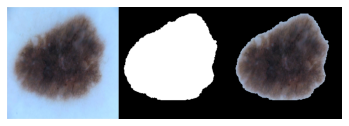

In [ ]:
xt = x[0]
yt = y[0]

plt.axis('off')
img = np.copy(xt)
msk = np.copy(yt.squeeze())
msk = np.stack((msk,)*3, axis=-1)
msk[msk != 0] = 1
plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))
#plt.imsave(image_writing_folder + 'file.jpg', np.concatenate([img, msk, img*msk], axis = 1))



In [ ]:
#from Stackoverflow
def ccw_sort(p):
    p = np.array(p)
    mean = np.mean(p,axis=0)
    d = p-mean
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]


In [ ]:
def boundary_map_loss_function(y_true, y_pred):
  y_true += 0.00001
  y_pred += 0.00001
  res = -y_true * tf.math.log(y_pred) - (1-tf.math.log(y_pred)) * (1-y_true)
  return res
  

In [ ]:
sz = (256, 256)
T = 1 #number of iterations
n = 10 # number of points

def bpb_downsamples(images):
  result_arr =[]
  counter = 0
  for SGT in images:
    edges = cv.Canny(SGT, 100, 200)
    edges[edges != 0] = 1

    nonzero_edges = np.nonzero(edges)
    contours = [ (nonzero_edges[1][i], nonzero_edges[0][i]) for i in range(len(nonzero_edges[1])) ]
    iou_best_image = None
    iou_best_image_tensor = None
    iou_best_val = tf.constant([0.0])
    for j in range(T):
      random_indices = np.random.randint(len(contours), size=n)
      points = np.zeros((n,2))
      for i in range(n):
        index = random_indices[i]
        points[i] = contours[index]

      points = ccw_sort(points)
      
      points = [tuple(point) for point in points]
      img = Image.new("RGB", sz, '#000')
      img1 = ImageDraw.Draw(img)
      img1.polygon(points, fill ="#fff", outline ="#fff") 

      y_pred = tf.keras.preprocessing.image.img_to_array(img)
      
      y_true = SGT
      y_true[y_true!=0] = 1
      y_pred[y_pred!=0] = 1
      iou_val = mean_iou2(y_pred, y_true)

      if tf.math.greater(iou_val, iou_best_val):
        iou_best_image = img
        iou_best_val = iou_val
        iou_best_image_tensor = y_pred 
    result_arr.append(iou_best_image_tensor)
  return result_arr


In [ ]:
created_images = bpb_downsamples(np.array(y))

In [ ]:
# model ve callback methodları burda
def unet_plus_segmentation_net(sz = ( 256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  f = 8
  layers = []
  outs_arr = []
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)

    out1 = Conv2D(f, 1, dilation_rate=1, padding='same', activation='relu')(x)
    out2 = Conv2D(f, 3, dilation_rate=1, padding='same', activation='relu')(x)
    out3 = Conv2D(f, 3, dilation_rate=2, padding='same', activation='relu')(x)
    out4 = Conv2D(f, 3, dilation_rate=4, padding='same', activation='relu')(x)
    out5 = Conv2D(f, 3, dilation_rate=6, padding='same', activation='relu')(x)

    temp = Concatenate()([out1, out2, out3, out4, out5])

    out  = Conv2D(1, 1, dilation_rate=1, padding='same', activation='sigmoid')(temp)
    outs_arr.append(out)
    temp = Multiply()([x, out])
    x = Add()([temp, x])
    layers.append(x)
    x = MaxPooling2D() (out)
    f = f*2
  ff2 = 64 


  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  
  out1 = Conv2D(f, 1, dilation_rate=1, padding='same', activation='relu')(x)
  out2 = Conv2D(f, 3, dilation_rate=1, padding='same', activation='relu')(x)
  out3 = Conv2D(f, 3, dilation_rate=2, padding='same', activation='relu')(x)
  out4 = Conv2D(f, 3, dilation_rate=4, padding='same', activation='relu')(x)
  out5 = Conv2D(f, 3, dilation_rate=6, padding='same', activation='relu')(x)

  temp = Concatenate()([out1, out2, out3, out4, out5])

  out  = Conv2D(1, 1, dilation_rate=1, padding='same', activation='sigmoid')(temp)
  outs_arr.append(out)
  temp = Multiply()([x, out])
  x = Add()([temp, x])
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 

  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    out1 = Conv2D(f, 1, dilation_rate=1, padding='same', activation='relu')(x)
    out2 = Conv2D(f, 3, dilation_rate=1, padding='same', activation='relu')(x)
    out3 = Conv2D(f, 3, dilation_rate=2, padding='same', activation='relu')(x)
    out4 = Conv2D(f, 3, dilation_rate=4, padding='same', activation='relu')(x)
    out5 = Conv2D(f, 3, dilation_rate=6, padding='same', activation='relu')(x)

    temp = Concatenate()([out1, out2, out3, out4, out5])

    out  = Conv2D(1, 1, dilation_rate=1, padding='same', activation='sigmoid')(temp)
    outs_arr.append(out)
    temp = Multiply()([x, out])
    x = Add()([temp, x])
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 

  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  outs_arr.append(outputs)
  outs_arr.append(outputs)
  #model creation 
  model = Model(inputs=[inputs], outputs=outs_arr)
  model.compile(optimizer = 'adam', loss = [boundary_map_loss_function] * 12 + ['binary_crossentropy'] + [sbe_loss_true], metrics = [mean_iou])

  return model

def build_callbacks():
  checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
  callbacks = [checkpointer, PlotLearning()]
  return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []
    self.acc = []
    self.val_acc = []
    #self.fig = plt.figure()
    self.logs = []
  def on_epoch_end(self, epoch, logs={}):
    print(logs)
    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.acc.append(logs.get('mean_iou'))
    self.val_acc.append(logs.get('val_mean_iou'))
    self.i += 1
    print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))





In [ ]:
def sbe_loss_general(y_true, y_pred):
  return -tf.math.log(1-y_pred+ 0.00001)-tf.math.log(y_pred + 0.00001)

def sbe_loss_true(y_true, y_pred):
  return -tf.math.log(y_pred + 0.00001)

In [ ]:
# training burda başlıyor. 
unet_bpb = unet_plus_segmentation_net()
unet_bpb.summary()

In [ ]:
def sbe_net(sz=(256,256, 2)):
  x = Input(sz)#Concatenate()([Spred, MGT])
  inp = x
  f = 4
  for i in range(0, 4):
    f *= 2
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = MaxPooling2D()(x)
  
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = GlobalAveragePooling2D()(x)
  out = Dense(1, activation='sigmoid')(x)


  #model creation 
  model = Model(inputs=[inp], outputs=[out])
  model.compile(optimizer = 'adam', loss = [sbe_loss_general])

  return model

In [ ]:
sbe_ = sbe_net()
sbe_.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 2)]     0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 256, 256, 8)       152       
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 256, 256, 8)       584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 16)        0   

In [ ]:
created_images = bpb_downsamples(y)

In [ ]:
down_samples = [np.zeros((900, 256, 256, 1)), 
                np.zeros((900, 128, 128, 1)),
                np.zeros((900, 64, 64, 1)),
                np.zeros((900, 32, 32, 1)),
                np.zeros((900, 16, 16, 1)),
                np.zeros((900, 8, 8, 1)),
                np.zeros((900, 4, 4, 1)),
                np.zeros((900, 8, 8, 1)),
                np.zeros((900, 16, 16, 1)),
                np.zeros((900, 32, 32, 1)),
                np.zeros((900, 64, 64, 1)),
                np.zeros((900, 128, 128, 1))]


In [ ]:
for j, created_image in enumerate(created_images):
  created_image = created_image[:,:,0]
  for i in range(6):
    down_samples[i][j,:,:,0] = created_image
    created_image = block_reduce(created_image, block_size=(2,2), func=np.max, cval=np.max(created_image))
    down_samples[11-i][j,:,:,0] = created_image
  down_samples[6][j,:,:,0] = created_image

y[y==0] = 1



In [ ]:
all_MGT = np.array(created_images)[:,:,:,0:1]

del created_images
real_inp = np.concatenate([y, all_MGT], axis=3)

out_size = all_MGT.shape[0]



In [ ]:
# firstly noise, then generator value
all_Spred = np.random.rand(out_size, 256, 256, 1)

fake_inp = np.concatenate([all_Spred, all_MGT], axis=3)
x = np.concatenate([real_inp, fake_inp], axis=0)
y = np.concatenate([tf.ones(out_size), tf.zeros(out_size)])

sbe_.fit(x = np.copy(x), y = y,  epochs = 1, batch_size=1, validation_split=0.05, verbose = 0)
discrimination = sbe_.predict(x)
print(discrimination.numpy())

unet_bpb.fit(x = x, y = down_samples + [y] + discrimination,  epochs = 1, batch_size=1, validation_split=0.05, verbose = 0)
all_Spred = unet_bpb.predict()



AttributeError: ignored

In [ ]:
t = down_samples[5][0]
print(t.shape)

t.resize((8,8))
plt.imshow(t)

In [ ]:
Spred = model.predict(np.expand_dims(train_batches[2], 0))[12]


In [ ]:
# prediction burda başlıyor

any_test_image = 'ph2 dataset/PH2 Dataset images/IMD003/IMD003_Dermoscopic_Image/IMD003.bmp'

raw = Image.open(any_test_image)
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))[12]
pred.resize(256,256)
print(pred.shape)
#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)

msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()
